# Mownit lab2

### Import bibliotek

In [2]:
from math import exp, sin, cos, pi
import matplotlib.pyplot as plt
import numpy as np

### Moja wersja funkcji:

In [3]:
#f7, k=3, m=2, [-pi, 2pi]
def f(x):
    return exp(-3 * sin(2*x)) + 3 * cos(2*x)

In [4]:
def f_d(x):
    return -6 * sin(2*x) - 6*exp(-3*sin(2*x))*cos(2*x)

In [5]:
x_start = -pi
x_end = 2*pi

## Algorytmy interpolacji

In [6]:
def Chebyshev_node(k, n):
    return 0.5*(x_start + x_end) + 0.5*(x_end - x_start) * cos(pi * (2*k+1) * (1/(2*n)))
def even_node(i, n):
    return x_start + i * (x_end - x_start)/(n-1)

def build_xy_data(points_number, nodes_method):
    x_points = [0] * points_number
    y_points = [0] * points_number
    for i in range(points_number):
        x_points[i] = nodes_method(i, points_number)
        y_points[i] = f(x_points[i])
    return x_points, y_points

In [7]:
build_xy_data(3,Chebyshev_node)

([5.651844896321887, 1.5707963267948968, -2.5102522427320926],
 [18.34898564633229, -1.9999999999999991, 0.9671323793121457])

## Przydatne funkcje

In [8]:
def pts(xs, ys):
    return [(xs[i],ys[i]) for i in range(len(xs))]

In [9]:
def newton_coefficient(xs, ys):
    m = len(xs)

    xs = np.copy(xs)
    a = np.copy(ys)
    for k in range(1, m):
        a[k:m] = (a[k:m] - a[k - 1])/(xs[k:m] - xs[k - 1])

    return a

def eval_lagrange(xs, ys, x):
    n = len(xs)
    y_eval = 0
    for i in range(n):
        p = 1
        for j in range(n):
            if i != j:
                p *=  (x - xs[j])/(xs[i] - xs[j])

        y_eval += p * ys[i] 
    return y_eval

def eval_newton(xs, ys, x):
    b = newton_coefficient(xs, ys)
    n = len(xs)-1
    y_eval = b[n]
    for k in range(1, n + 1):
        y_eval = b[n - k] + (x - xs[n - k])*y_eval

    return y_eval
    

## Zagadnienie Hermita

In [10]:
def hermit_interpolate(X, Y): 
    n = len(X)
    X = list(X)
    Y = list(Y)
    points = np.zeros(shape=(2 * n + 1, 2 * n + 1))

    for i in range(0, 2 * n, 2):
        points[i][0] = X[i // 2]
        points[i + 1][0] = X[i // 2]
        points[i][1] = Y[i // 2]
        points[i + 1][1] = Y[i // 2]

    for i in range(2, 2 * n + 1):
        for j in range(1 + (i - 2), 2 * n):
            if i == 2 and j % 2 == 1:
                points[j][i] = f_d(X[j // 2]);

            else:
                points[j][i] = (points[j][i - 1] - points[j - 1][i - 1]) / (
                    points[j][0] - points[(j - 1) - (i - 2)][0])

    def result_polynomial(xs, ys, xpoint):  #here is function to calculate value for given x
        val = 0
        for i in range(0, 2 * n):
            factor = 1.
            j = 0
            while j < i:
                factor *= (xpoint - X[j // 2])
                if j + 1 != i:
                    factor *= (xpoint - X[j // 2])
                    j += 1
                j += 1
            val += factor * points[i][i + 1]
        return val
    return result_polynomial

### Proste testy

In [11]:
xs, ys = build_xy_data(100,Chebyshev_node)
x_e = 0
y_e = eval_lagrange(xs, ys, x_e)

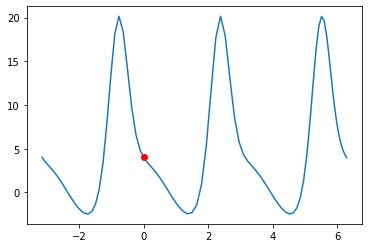

In [12]:
plt.plot(xs,ys)
plt.plot(x_e,y_e,"or")

### Wizualizacja interpolacji

In [13]:
def gen_points(int_fun, xs, ys, n):
    x_delta = (x_end - x_start)/(n-1)
    xt = []
    yt = []
    for i in range(n):
        x = x_start + i * x_delta
        xt.append(x)
        yt.append(int_fun(xs,ys,x))
    return xt, yt

In [14]:
def visualize(n, node_method, eval_method):
    xs, ys = build_xy_data(n,node_method)
    xt, yt = gen_points(eval_method, xs, ys, 100)
    plt.plot(xt,yt)
    xp,yp = build_xy_data(100,even_node)
    plt.plot(xp,yp)
    plt.scatter(xs,ys, c = ["#000000"])

## Wizualizacja zagadnienia Lagrange'a

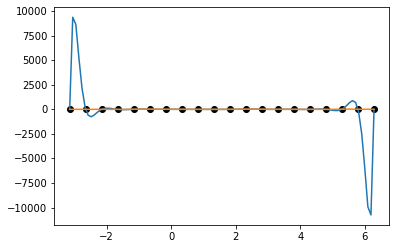

In [15]:
visualize(20,even_node,eval_lagrange)

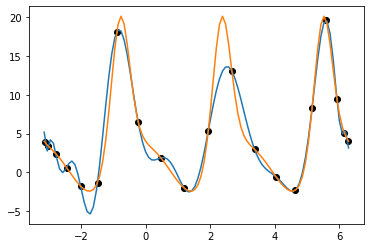

In [16]:
visualize(20,Chebyshev_node,eval_lagrange)

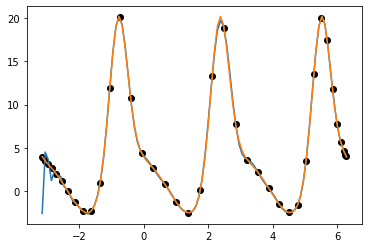

In [17]:
visualize(40,Chebyshev_node,eval_newton)

## Wizualizacja zagadnienia Hermite'a

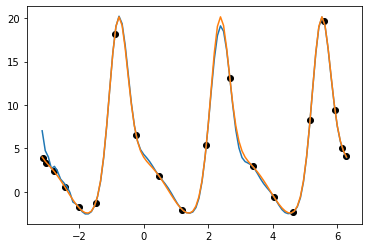

In [18]:
def visualize_hermit(n, node_method):
    xs, ys = build_xy_data(n,node_method)
    int_fun = hermit_interpolate(xs,ys)
    xt, yt = gen_points(int_fun, xs, ys, 100)
    plt.plot(xt,yt)
    xp,yp = build_xy_data(100,even_node)
    plt.plot(xp,yp)
    plt.scatter(xs,ys, c = ["#000000"])

visualize_hermit(20,Chebyshev_node)

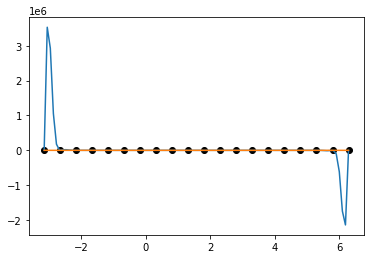

In [19]:
visualize_hermit(20,even_node)

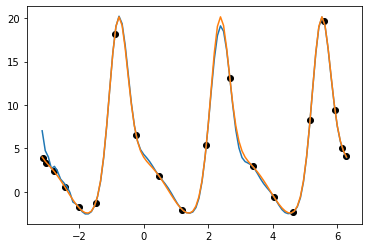

In [20]:
visualize_hermit(20,Chebyshev_node)

## Wyliczanie błędów w obliczeniach

In [21]:
def diff_lagrange(n, test_m, node_m, eval_m):
    xs, ys = build_xy_data(n,node_m)
    xt, yt = gen_points(eval_m, xs, ys, 100)
    xp, yp = build_xy_data(100,even_node)
    return test_m([abs(yp[i]-yt[i]) for i in range(len(yp))])

def diff_hermit(n, test_m, node_m, tmp):
    xs, ys = build_xy_data(n,node_m)
    int_fun = hermit_interpolate(xs,ys)
    xt, yt = gen_points(int_fun, xs, ys, 100)
    xp, yp = build_xy_data(100,even_node)
    return test_m([abs(yp[i]-yt[i]) for i in range(len(yp))])

In [22]:
diff_lagrange(40,max,Chebyshev_node, eval_lagrange)

0.560790790124539

In [23]:
diff_hermit(40,max,Chebyshev_node, "")

179339452508017.12

In [24]:
diff_lagrange(40,max,Chebyshev_node, eval_newton)

6.528125879612071

In [25]:
diff_lagrange(40,np.mean,Chebyshev_node, eval_newton)

0.19976215230536518

## Wizualizacja zależności błędu od liczby węzłów

In [48]:
def visualize_diff(test_m, node_m, eval_m, diff_m, start_n, end_n):
    xn = [i for i in range(start_n, end_n+1)]
    yn = [diff_m(i, test_m, node_m, eval_m) for i in range(start_n, end_n+1)]
    plt.plot(xn,yn)
    plt.xticks(xn)

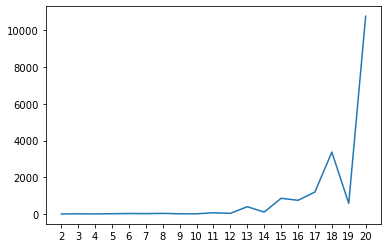

In [61]:
visualize_diff(max,even_node, eval_lagrange, diff_lagrange, 2, 20)

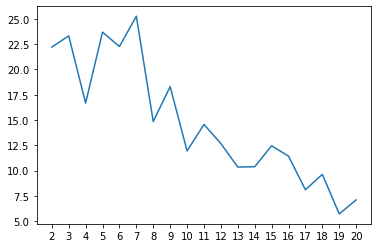

In [60]:
visualize_diff(max,Chebyshev_node, eval_lagrange, diff_lagrange, 2, 20)

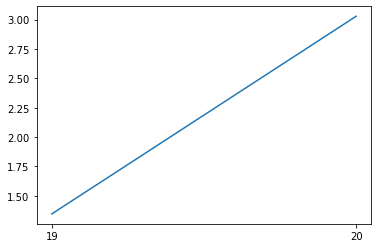

In [59]:
visualize_diff(max,Chebyshev_node, eval_lagrange, diff_hermit, 19, 20)